# Bovine Tuberculosis by county

This analysis shows the Bovine TB statistics for counties in Ireland. The data used can be found here.
https://data.gov.ie/dataset/bovine-tuberculosis-by-regional-veterinary-offices-year-and-statistic    


In [80]:
from pyjstat import pyjstat
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import folium
from folium import plugins
import os
import json
import numpy as np

## Global vars

In [81]:
reg_vet_office = 'Regional Veterinary Offices'
stat = 'Reactors to date (Number)'

## Utility functions

In [82]:
def strip_file_name(input, chars_to_strip = '/:.'):
    """ 
    We are going to use the url as a key for our local filesystem cache.
    To get this to work we need to remove some characters from the filename which are invalid in filenames.
    """
    for char in chars_to_strip:
        input = input.replace(char, '')
    return input

In [83]:
def read_jsonstat(file_name):
    """
    This class helps us avoid hitting the CSO website every time we want to produce the graph.
    Instead the stripped url is used as a file name to store the json locally.

    Steps in this function:
    Strip the filename. 
    If that version exists locally, return it as json-stat
    otherwise read it from the url and write to the fs before returning as json-stat
    https://pypi.org/project/pyjstat/
    """
    temp_file_name = strip_file_name(file_name)
    local_file_name = Path(temp_file_name)
    if local_file_name.is_file():
        print("File exists")
        f = open(local_file_name, 'r')
        content = f.read()
        # convert to pyjstat format from str
        content = pyjstat.Dataset.read(content)
    else:
        print("File is missing")
        content = pyjstat.Dataset.read(file_name)
        f = open(temp_file_name, 'w')
        f.write(content.write())
        f.close()
    return content

In [84]:
def get_counties_from_y(data, desired_column = 'county', exclusions = []):
    """
    Given the dataframe containing the counties return the sorted set of counties
    """
    before_exclusions = set(data[desired_column])
    for label in exclusions:
        before_exclusions.discard(label)
    return before_exclusions

In [85]:
def merge_counties(df, county_tuples):
    """
    To create a choropleth we need to make sure the labels in the geojson match those in the data for display.
    This function takes 2 county names and a new name and merges the 2 into the new one by summing.
    For example Wicklow W and Wicklow E go to Wicklow.
    """
    for county_tuple in county_tuples:
        df.loc[df[reg_vet_office]==county_tuple[0],reg_vet_office] = county_tuple[1]
        df = df.groupby([reg_vet_office, 'Year', 'Statistic'], as_index=False).sum()    
        df.loc[df[reg_vet_office]==county_tuple[1],reg_vet_office] = county_tuple[2]
    return df

In [86]:
def get_counties_from_geojson():
    ireland_counties = os.path.join('data', 'ireland.json')
    geo_json_data = json.load(open(ireland_counties))
    return [x["properties"]['id'] for x in geo_json_data['features']]

In [87]:
def set_diff_described(list1, list2):
    first = set(list1).difference(set(list2))
    second = set(list2).difference(set(list1))
    if not len(first) and not len(second):
        return 'Lists match.'
    else:
        return 'In first but not second '+str(first)+\
    '. in second, but not first '+str(second)

# Main body of the program


In [88]:
URL = 'https://www.cso.ie/StatbankServices/StatbankServices.svc/\
jsonservice/responseinstance/DAA01'

# read from json-stat
dataset = read_jsonstat(URL)

df = dataset.write('dataframe')

# Change the year to an int
df['Year'] = df['Year'].map(int)

# Filter the df to only contain 'Reactors to date (Number)'
# Remove 'State' from the list => counties only
df = df[(df[reg_vet_office]!='State') & (df['Statistic']==stat)]

df = merge_counties(df, 
                    [('Wicklow W', 'Wicklow E', 'Wicklow'), 
                    ('Cork North', 'Cork South', 'Cork'), 
                    ('Tipperary North', 'Tipperary South', 'Tipperary')]
                   )

# Show that Cork North and Cork South are merged
df[df[reg_vet_office]=='Cork'].head()

File exists


,Regional Veterinary Offices,Year,Statistic,value
24,Cork,2010,Reactors to date (Number),2670.0
25,Cork,2011,Reactors to date (Number),2505.0
26,Cork,2012,Reactors to date (Number),2497.0
27,Cork,2013,Reactors to date (Number),2051.0
28,Cork,2014,Reactors to date (Number),2068.0


In [89]:
counties_from_df = get_counties_from_y(df, desired_column = reg_vet_office, exclusions = ['State'])
counties_from_geojson = get_counties_from_geojson()
print(set_diff_described(counties_from_df, counties_from_geojson))

Lists match.


In [90]:
df.rename(columns={'Regional Veterinary Offices': 'county'}, inplace=True)

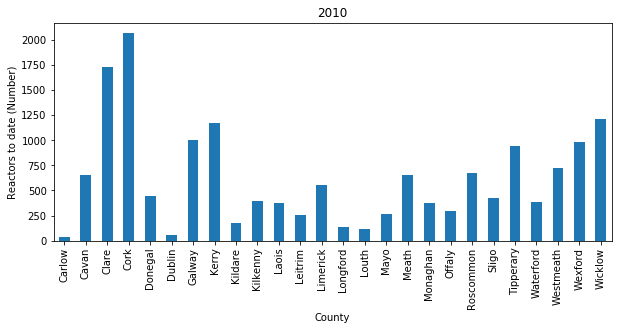

In [91]:
df = df[df['Year']==2014]
ax = df.plot(kind='bar', x = 'county', y = 'value', figsize=(10,4))
ax.set_ylabel(stat)
ax.set_xlabel('County')
ax.set_title('2010')
legend = ax.legend()
legend.remove()
plt.show()

In [92]:
from branca.colormap import linear
colormap = linear.YlGn_09.scale(
    df['value'].min(),
    df['value'].max())
print(colormap(5.0))
colormap

#ffffe5


In [93]:
tb_dict = df.set_index('county')['value']

In [94]:
ireland_counties = os.path.join('data', 'ireland.json')
geo_json_data = json.load(open(ireland_counties))
    
m = folium.Map([53.14, -7.69], zoom_start=7, tiles='Mapbox Bright')
colormap.add_to(m)
folium.GeoJson(
    geo_json_data,
    name='tb',
    style_function=lambda feature: {
        'fillColor': colormap(tb_dict[feature['properties']['id']]),   
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5,
    }
).add_to(m)

plugins.ScrollZoomToggler().add_to(m)
#folium.LayerControl().add_to(m)
m